# Classification of P300 Event-Related Potentials and <br /> Data Preparation for 64-Channel BioSemi  Data

__Elliott Forney - 2020__

In [1]:
import pickle

import math
import numpy as np
import scipy as sp
import scipy.signal as _

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8.5]

In [2]:
!ls ~/data/eeg/csu/subject-052/

s12-d1-p300grid-test-rocks.pkl		 s12-d1-p300grid-test-university.pkl
s12-d1-p300grid-test-rocks.png		 s12-d1-p300grid-test-university.png
s12-d1-p300grid-test-state.pkl		 s12-d1-p300grid-train-colorado.pkl
s12-d1-p300grid-test-state.png		 s12-d1-p300grid-train-colorado.txt
s12-d1-p300grid-test-summer-3trials.png


In [3]:
subject = 52

In [4]:
with open(f'data/subject-{subject:03}/s12-d1-p300grid-train-colorado.pkl', mode='rb') as fh:
    raw_train_data = pickle.load(fh, encoding='bytes')

In [5]:
with open(f'data/subject-{subject:03}/s12-d1-p300grid-test-state.pkl', mode='rb') as fh:
    raw_valid_data = pickle.load(fh, encoding='bytes')

In [6]:
with open(f'data/subject-{subject:03}/s12-d1-p300grid-test-university.pkl', mode='rb') as fh:
    raw_test_data = pickle.load(fh, encoding='bytes')

In [7]:
raw_train_data.shape, raw_valid_data.shape, raw_test_data.shape

((255983, 73), (165910, 73), (201090, 73))

In [8]:
chan_names = (
    'Fp1', 'AF7', 'AF3', 'F1',  'F3',  'F5',  'F7',  'FT7',                                  
    'FC5', 'FC3', 'FC1', 'C1',  'C3',  'C5',  'T7',  'TP7',                                  
    'CP5', 'CP3', 'CP1', 'P1',  'P3',  'P5',  'P7',  'P9',                                   
    'PO7', 'PO3', 'O1',  'Iz',  'Oz',  'POz', 'Pz',  'CPz',                                  
    'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz',  'F2',  'F4',                                   
    'F6',  'F8',  'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',                                   
    'C2',  'C4',  'C6',  'T8',  'TP8', 'CP6', 'CP4', 'CP2',                                  
    'P2',  'P4',  'P6',  'P8',  'P10', 'PO8', 'PO4', 'O2',                                   
    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8',
    'MARKER'
)

In [9]:
def plot_trace(data, samp_rate, chan_names=chan_names, nsec=10, scale_factor=1.0):
    assert isinstance(data, np.ndarray)
    assert data.ndim == 2
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    nstep = nsec * samp_rate
    data = data[:nstep]
    
    nchan = data.shape[1]
    chan_names = chan_names[:nchan]
    
    scale = np.max(np.abs(data))                                                                                                                                                                   
    sep = -np.arange(data.shape[1]) * scale_factor * scale
    data = data + sep
        
    time = np.linspace(0, nsec, data.shape[0])
    
    ax.plot(time, data)
    ax.set_xlabel(r'Time ($s$)')
    ax.set_ylabel(r'Signal ($\mu V$) Across Channels')
    ax.set_yticks(sep)
    ax.set_yticklabels([c for i, c in enumerate(chan_names)])
    ax.autoscale(tight=True)

73 73


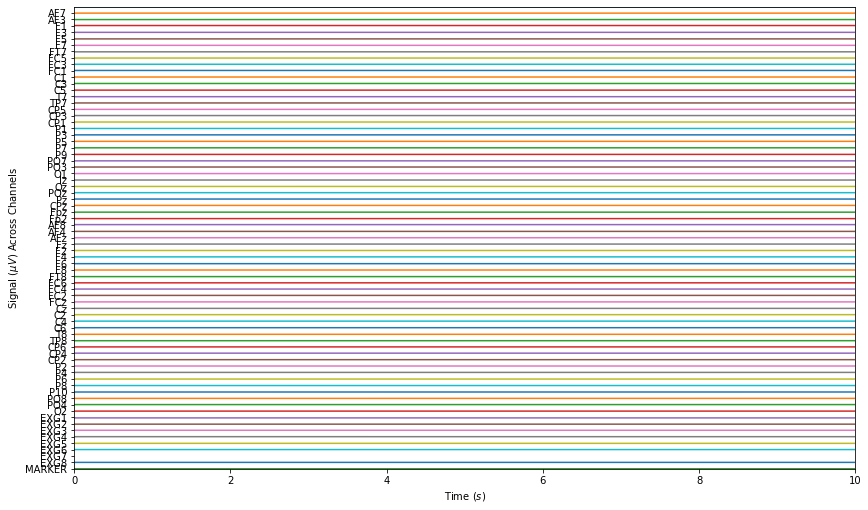

In [10]:
print(len(chan_names), raw_train_data.shape[1])
plot_trace(raw_train_data, samp_rate=1024)

In [11]:
train_data = raw_train_data.copy()

In [12]:
train_data -= train_data.mean(axis=0)

In [13]:
ref_chan_idxs = chan_names.index('EXG5'), chan_names.index('EXG6')
ref_chan_idxs

(68, 69)

In [14]:
reference = train_data[:, ref_chan_idxs].mean(axis=1)[:, None]
reference.shape

(255983, 1)

In [15]:
train_data -= reference

In [16]:
train_data -= train_data.mean(axis=0)

In [17]:
train_data = train_data[:, :64]

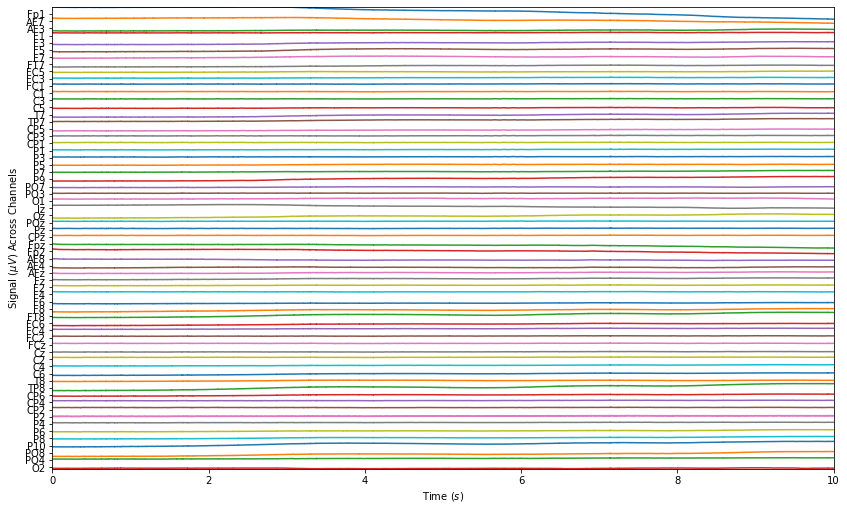

In [18]:
plot_trace(train_data, samp_rate=1024)

In [19]:
#select_chan_names = (
#    'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2',                 
#    'Fz', 'O1', 'O2', 'P3', 'P4', 'P7', 'P8', 'Pz', 'T7', 'T8'
#)
select_chan_names = (
    'Cz', 'Fz', 'Oz', 'P3', 'P4', 'P7', 'P8', 'Pz',
)

In [20]:
select_chan_idxs = [chan_names.index(chan_name) for chan_name in select_chan_names]
train_data = train_data[:, select_chan_idxs]

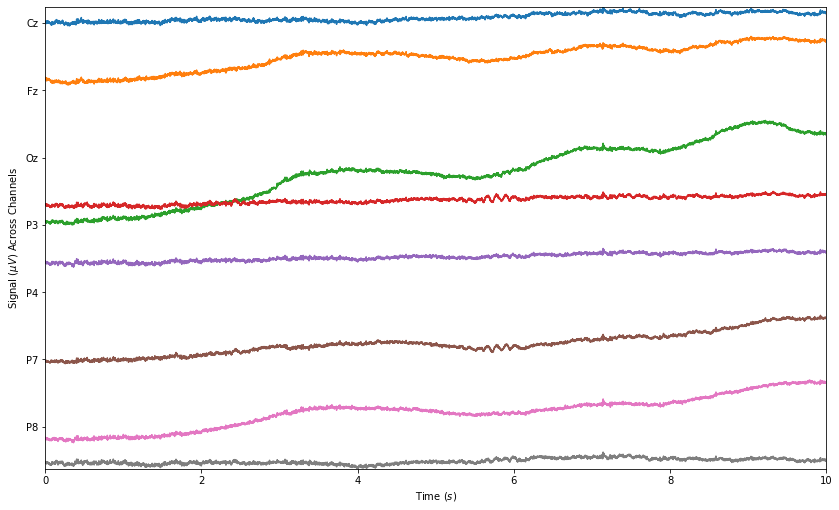

In [21]:
plot_trace(train_data, samp_rate=1024, chan_names=select_chan_names)

In [22]:
def make_bandpass(samp_rate, low_freq, high_freq, order=6):
    '''Bidirectional Butterworth linear IIR bandpass filter as a cascade of second order sections.
    '''  
    # compute the filter coefficients
    sos = sp.signal.iirfilter(
        order, (low_freq, high_freq), ftype='butter', btype='bandpass', fs=samp_rate, output='sos')
    
    def bandpass(data):
        # apply the filter in both directions
        return sp.signal.sosfiltfilt(sos, data, axis=0, padtype='even')
    
    return bandpass

In [23]:
bandpass = make_bandpass(samp_rate=1024, low_freq=0.5, high_freq=24.0)

In [24]:
train_data = bandpass(train_data)

In [25]:
1024 / 16

64.0

In [26]:
downsample_factor = 16

In [27]:
train_data = train_data[::downsample_factor]

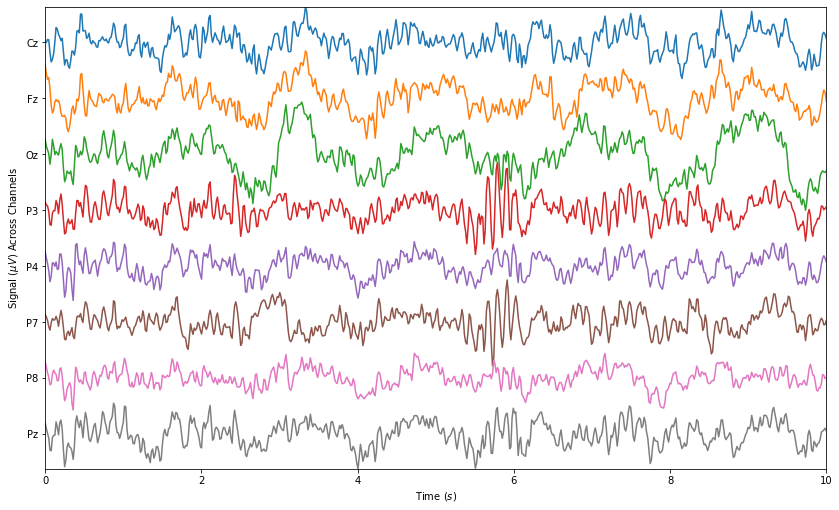

In [28]:
plot_trace(train_data, samp_rate=64, chan_names=select_chan_names)

## Welch's Power Spectral Density (PSD) to verify frequency content

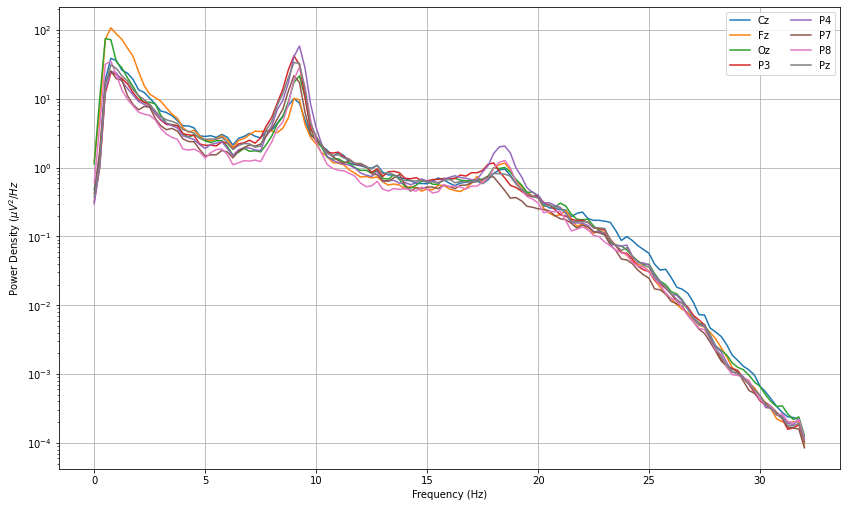

In [29]:
freqs, powers = sp.signal.welch(train_data.T, 64.0)

plt.plot(freqs, powers.T);
plt.xlabel('Frequency (Hz)');
plt.ylabel(r'Power Density ($\mu V^2/Hz$');
plt.yscale('log');
plt.grid();
plt.legend(select_chan_names, ncol=2);

## Don't forget the marker channel

In [30]:
train_markers = raw_train_data[::downsample_factor, -1]
valid_markers = raw_valid_data[::downsample_factor, -1]
test_markers = raw_test_data[::downsample_factor, -1]

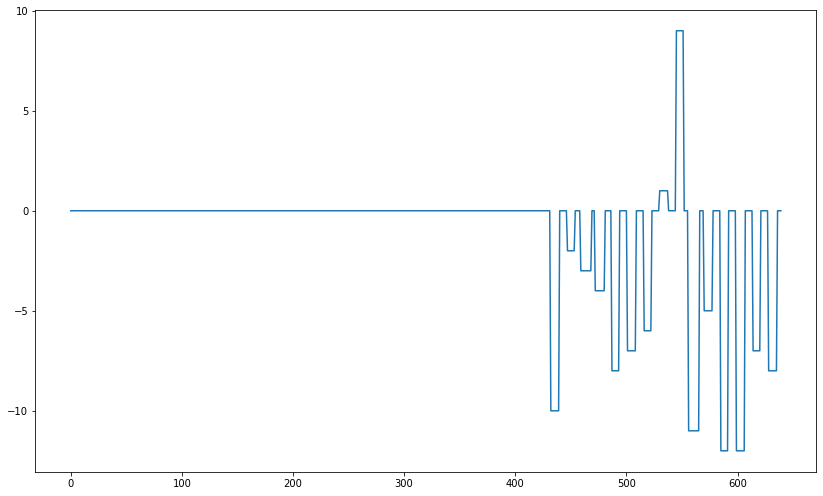

In [31]:
plt.plot(train_markers[:64*10]);

## Putting all the preprocessing together

In [32]:
def preprocess(raw_data, raw_samp_rate=1024, low_freq=0.5, high_freq=24.0, downsample_factor=16,
               chan_names=chan_names, select_chan_names=select_chan_names):
    # copy
    data = raw_data.copy()
    
    # demean
    data -= data.mean(axis=0)
    
    # reference
    ref_chan_idxs = chan_names.index('EXG5'), chan_names.index('EXG6')
    reference = data[:, ref_chan_idxs].mean(axis=1)[:, None]
    data -= reference
    
    # use only selected channels
    select_chan_idxs = [chan_names.index(chan_name) for chan_name in select_chan_names]
    data = data[:, select_chan_idxs]
    
    # bandpass
    # FIXME: very inefficent to recreate the filter for each
    #   call... but works for now
    bandpass = make_bandpass(
        samp_rate=raw_samp_rate,
        low_freq=low_freq, high_freq=high_freq)
    data = bandpass(data)[::downsample_factor]
    
    # extract marker channel
    markers = raw_data[::downsample_factor, -1]
    
    return data, markers

In [33]:
train_data, train_markers = preprocess(raw_train_data)
valid_data, valid_markers = preprocess(raw_valid_data)
test_data, test_markers = preprocess(raw_test_data)

## Segmenting the data

In [34]:
diffs = np.diff(np.abs(train_markers))
diffs, diffs.shape

(array([0., 0., 0., 0., ..., 0., 0., 0., 0.]), (15998,))

In [35]:
starts = np.where(diffs > 0.0)[0] + 1
starts, starts.shape

(array([  432,   447,   459,   472, ..., 15861, 15876, 15890, 15905]), (960,))

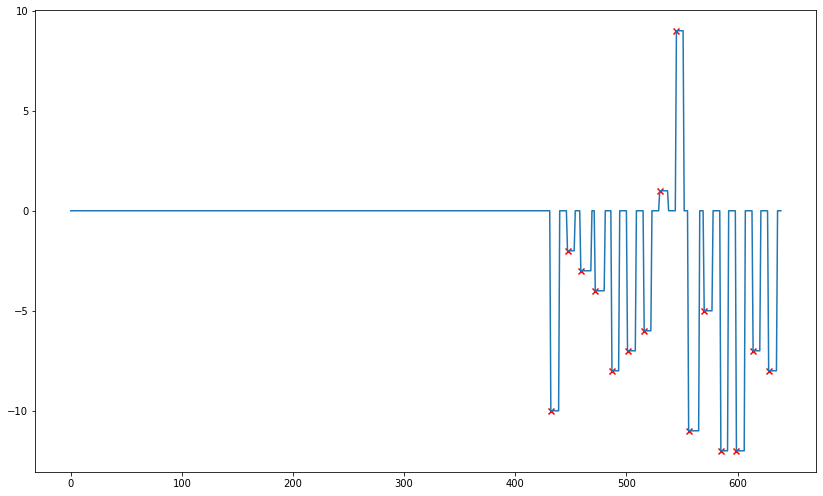

In [36]:
plt.plot(train_markers[:64*10]);
plt.scatter(starts[:15], train_markers[starts[:15]], marker='x', color='red');

In [37]:
segment_width_steps = int(0.8 * 64.0)
segment_width_steps

51

In [38]:
train_segments = np.stack([train_data[start:start+segment_width_steps] for start in starts])
train_segments.shape

(960, 51, 8)

In [39]:
labels = (train_markers[starts] > 0.0).astype(np.int)
labels, labels.shape

(array([0, 0, 0, 0, ..., 0, 0, 0, 0]), (960,))

In [40]:
np.sum(labels == 0)

800

In [41]:
np.sum(labels == 1)

160

## Putting segmentation steps together

In [42]:
def segment(data, markers, samp_rate=64.0, width=0.8):
    diffs = np.diff(np.abs(markers))
    starts = np.where(diffs > 0.0)[0] + 1
    
    width_steps = int(width * samp_rate)
    
    segments = np.stack([data[start:start+width_steps] for start in starts])
    labels = (markers[starts] > 0.0).astype(np.int)
    
    return np.ascontiguousarray(segments), labels

In [43]:
train_data, train_labels = segment(train_data, train_markers)
valid_data, valid_labels = segment(valid_data, valid_markers)
test_data, test_labels = segment(test_data, test_markers)

train_data.shape, valid_data.shape, test_data.shape

((960, 51, 8), (600, 51, 8), (600, 51, 8))

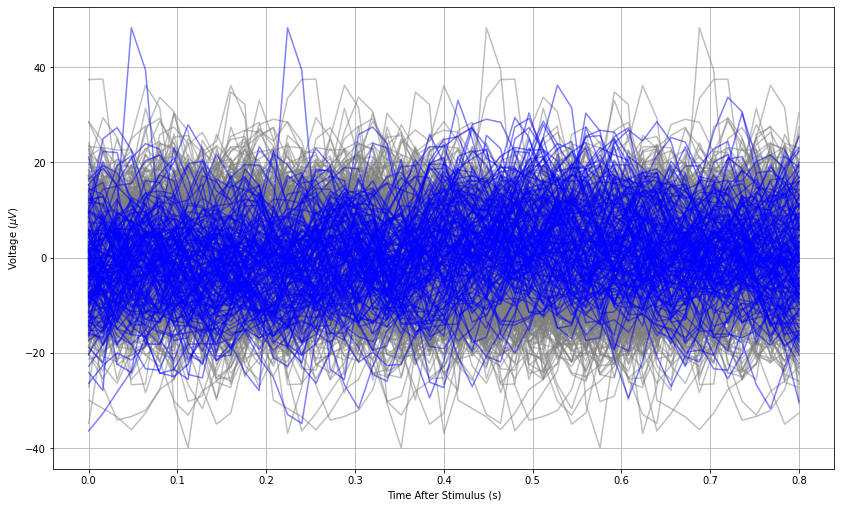

In [44]:
cz_index = select_chan_names.index('Cz')
time = np.linspace(0.0, 0.8, train_data.shape[1])

targets = train_data[train_labels == 0, :, cz_index]
nontargets = train_data[train_labels == 1, :, cz_index]

plt.plot(time, targets.T, color='grey', alpha=0.5);
plt.plot(time, nontargets.T, color='blue', alpha=0.5);
plt.xlabel('Time After Stimulus (s)')
plt.ylabel(r'Voltage ($\mu V$)')
plt.grid();

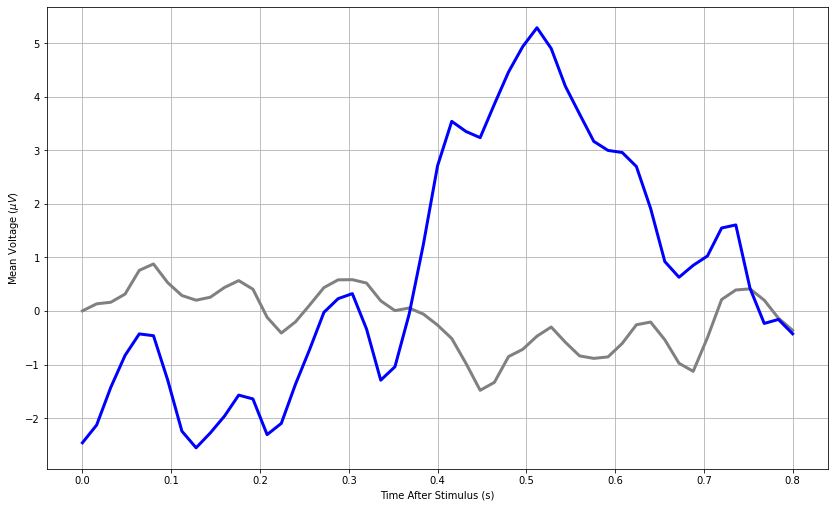

In [45]:
plt.plot(time, targets.mean(0), color='grey', linewidth=3, label='Target');
plt.plot(time, nontargets.mean(0), color='blue', linewidth=3, label='Nontarget');
plt.xlabel('Time After Stimulus (s)')
plt.ylabel(r'Mean Voltage ($\mu V$)')
plt.grid();

## Standardization

In [46]:
def make_standardizer(data):
    '''Standardize so that each channel has zero mean and unit variance.
    '''
    assert data.ndim == 3
    flat_data = data.reshape((-1, data.shape[-1]))
    means = flat_data.mean(0)
    stdevs = flat_data.std(0)
    
    def standardizer(data):
        return (data - means) / stdevs
    
    return standardizer

In [47]:
standardizer = make_standardizer(train_data)

std_train_data = standardizer(train_data)
std_valid_data = standardizer(valid_data)
std_test_data = standardizer(test_data)

(std_test_data.reshape((-1, std_test_data.shape[-1])).mean(0),
 std_test_data.reshape((-1, std_test_data.shape[-1])).std(0))

(array([ 0.0037, -0.0024, -0.0009,  0.0037,  0.0027, -0.0001, -0.0005,
         0.0056]),
 array([1.0446, 0.866 , 0.8352, 1.0283, 1.006 , 0.9891, 0.9429, 1.0576]))

# Classification with Logistic Regression

In [48]:
import functools, munch

import torch as th
import sklearn
import sklearn.metrics

In [195]:
def numpy_func(func):
    '''Decorator for methods that take a single NumPy array called `data` as
    an argument and return a NumPy array but process Torch arrays internally.
    '''
    @functools.wraps(func)
    def wrapper(self, data):
        with th.no_grad():
            return func(self, th.as_tensor(data, dtype=th.float32)).numpy()

    return wrapper

class P300Classifier(th.nn.Module):
    '''Parent class for neural-net P300 classifiers.
    '''
    def __init__(self):
        '''Constructor initializes Torch module.  Override this and put
        your network's initialization here, don't forget to call `super()`.
        '''
        super().__init__()
    
    @numpy_func
    def labels(self, data):
        '''Assign integer labels to each data segment.
        '''
        return th.argmax(self(data), axis=1)
    
    @numpy_func
    def probs(self, data):
        '''Apply a softmax to the output of the forward pass
        and return predicted class membership probabilities.
        '''
        return th.nn.functional.softmax(self(data), dim=1)
    
    def forward(self, data):
        '''Forward pass of the net, operates over Torch arrays.
        Override this and put your network's forward pass here.
        '''
        raise NotImplementedError(f'forward pass not defined for {self.__class__.__name__}')
    
    def fit(self, train_data, train_labels, valid_data, valid_labels, maxiter=500):
        '''Tune the weights of the neural network using RProp.
        '''
        train_data = th.as_tensor(train_data, dtype=th.float32)
        train_labels = th.as_tensor(train_labels, dtype=th.int64)
        valid_data = th.as_tensor(valid_data, dtype=th.float32)
        valid_labels = th.as_tensor(valid_labels, dtype=th.int64)
        
        result = munch.Munch({
            'train_losses': [],
            'valid_losses': [],
            'best_iter': 0,
            'best_train_loss': np.inf,
            'best_valid_loss': np.inf,
        })
        best_state = None
        
        loss_func = th.nn.CrossEntropyLoss(reduction='mean')
        optimizer = th.optim.Rprop(self.parameters())

        for it in range(maxiter):
            self.train()
            optimizer.zero_grad()
            
            logits = self(train_data)
            loss = loss_func(logits, train_labels)
            result.train_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            
            self.eval()
            with th.no_grad():
                logits = self(valid_data)
                loss = loss_func(logits, valid_labels)
                result.valid_losses.append(loss.item())
                
            if result.valid_losses[-1] < result.best_valid_loss:
                result.best_train_loss = result.train_losses[-1]
                result.best_valid_loss = result.valid_losses[-1]
                result.best_iter = it
                best_state = self.state_dict()
                
        self.load_state_dict(best_state)
                
        self.eval()
                
        return result
    
    def ca(self, data, labels):
        '''Find the Classification Accuracy (CA) for the given data and
        ground-truth labels.
        '''
        preds = self.labels(data)
        return sklearn.metrics.accuracy_score(labels, preds)
    
    def bca(self, data, labels):
        '''Find the Balanced Classification Accuracy (BCA) for the given
        data and ground-truth labels.
        '''
        preds = self.labels(data)
        return sklearn.metrics.balanced_accuracy_score(labels, preds)
    
    def auc(self, data, labels):
        '''Find the Area Under the receiver operating characteristic Curve (AUC)
        for the given data and ground truth labels.  This is the recommended
        metric for comparing P300 spellers because we are ultimately interested
        in the likelihood that a target is assigned a higher score than a
        nontarget because we will aggregate multiple trials in practice.
        '''
        probs = self.probs(data)
        return sklearn.metrics.roc_auc_score(labels, probs[:, 1])

In [196]:
class LogisticRegression(P300Classifier):
    '''Simple logistic regression over all timesteps concatenated
    across all channels.
    '''
    def __init__(self, nstep, nchan, ncls):
        super().__init__()
        self.visible = th.nn.Linear(nstep * nchan, ncls)
        
    def forward(self, data):
        data = th.as_tensor(data, dtype=th.float32)
        assert data.ndim == 3
        
        return self.visible(data.reshape(data.shape[0], -1))

In [197]:
logreg = LogisticRegression(std_train_data.shape[1], std_train_data.shape[2], 2)
print('model parameters:', sum(params.nelement() for params in logreg.parameters()))

model parameters: 818


In [198]:
result = logreg.fit(std_train_data, train_labels, std_valid_data, valid_labels, maxiter=250)

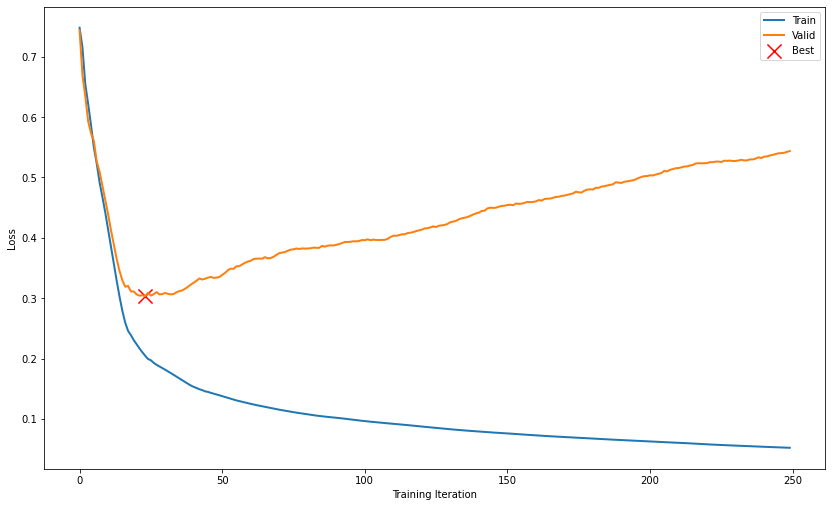

In [199]:
plt.plot(result.train_losses, linewidth=2, label='Train');
plt.plot(result.valid_losses, linewidth=2, label='Valid');
plt.scatter((result.best_iter,), (result.best_valid_loss,), marker='x', s=200, color='red', label='Best');
plt.legend();
plt.xlabel('Training Iteration');
plt.ylabel('Loss');

In [200]:
model = logreg

print('train CA:', model.ca(std_train_data, train_labels))
print('valid CA:', model.ca(std_valid_data, valid_labels))
print('test CA:', model.ca(std_test_data, test_labels))
print('-------')
print('train BCA:', model.bca(std_train_data, train_labels))
print('valid BCA:', model.bca(std_valid_data, valid_labels))
print('test BCA:', model.bca(std_test_data, test_labels))
print('-------')
print('train AUC:', model.auc(std_train_data, train_labels))
print('valid AUC:', model.auc(std_valid_data, valid_labels))
print('test AUC:', model.auc(std_test_data, test_labels))

train CA: 0.9875
valid CA: 0.875
test CA: 0.855
-------
train BCA: 0.97
valid BCA: 0.761
test BCA: 0.7330000000000001
-------
train AUC: 0.999203125
valid AUC: 0.8518600000000001
test AUC: 0.85336


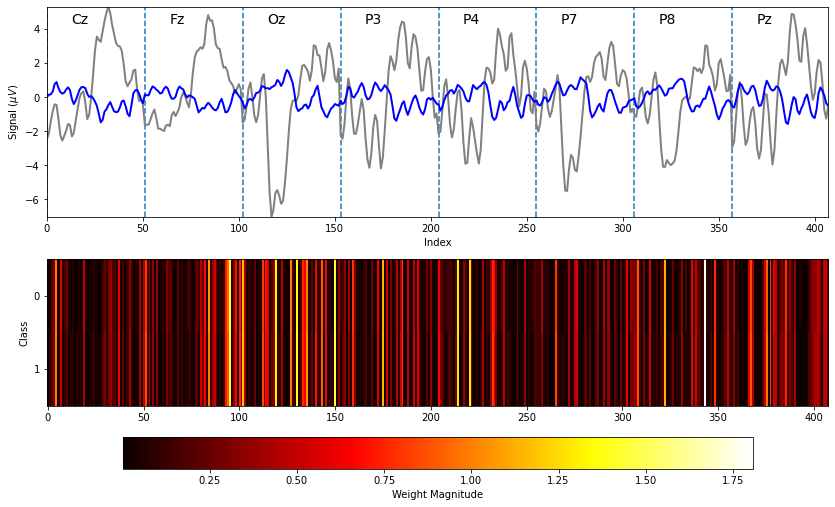

In [201]:
weights = logreg.visible.weight.detach().numpy()

mean_targets = train_data[train_labels == 0].mean(0)
mean_nontargets = train_data[train_labels == 1].mean(0)

fig = plt.figure()
ax_sig = fig.add_subplot(2, 1, 1)
ax_sig.plot(mean_nontargets.T.reshape((-1,)), linewidth=2, color='grey')
ax_sig.plot(mean_targets.T.reshape((-1,)), linewidth=2, color='blue')
ax_sig.set_xlabel('Index')
ax_sig.set_ylabel(r'Signal ($\mu V$)')
ax_sig.autoscale(tight=True)

mn = np.min(np.vstack((mean_targets, mean_nontargets)))
mx = np.max(np.vstack((mean_targets, mean_nontargets)))

for i, chan_name in enumerate(select_chan_names):
    ax_sig.vlines((i * mean_targets.shape[0],), mn, mx, linestyle='--');
    ax_sig.text((i + 0.25) * mean_targets.shape[0], mx - 1.0, chan_name, fontsize=14)

ax_weights = fig.add_subplot(2, 1, 2)
img = ax_weights.imshow(np.abs(weights), aspect='auto', interpolation='none', cmap=plt.cm.hot)
ax_weights.set_yticks(range(weights.shape[0]))                                                                                                   
ax_weights.set_ylabel('Class')                                                                   
ax_weights.autoscale(tight=True)
cb = plt.colorbar(img, ax=ax_weights, orientation='horizontal');
cb.set_label('Weight Magnitude');

## Logistic regression over learned linear components

In [202]:
class ComponentLogisticRegression(P300Classifier):
    '''Simple logistic regression over all timesteps concatenated
    across a linear combination of all channels, i.e., over learned components.
    '''
    def __init__(self, nstep, nchan, ncomp, ncls):
        super().__init__()
        self.component_proj = th.nn.Linear(nchan, ncomp)
        self.visible = th.nn.Linear(nstep * ncomp, ncls)
        
    @numpy_func
    def components(self, data):
        return self.component_proj(data)
        
    def forward(self, data):
        data = th.as_tensor(data, dtype=th.float32)
        assert data.ndim == 3
        
        comp = self.component_proj(data)
        return self.visible(comp.reshape(comp.shape[0], -1))

In [203]:
clogreg = ComponentLogisticRegression(std_train_data.shape[1], std_train_data.shape[2], 2, 2)
print('model parameters:', sum(params.nelement() for params in clogreg.parameters()))

model parameters: 224


In [204]:
cresult = clogreg.fit(std_train_data, train_labels, std_valid_data, valid_labels, maxiter=250)

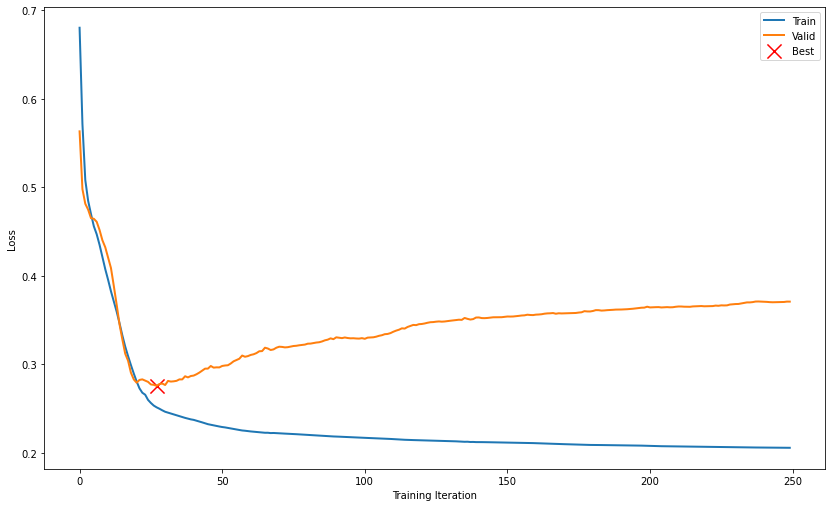

In [205]:
plt.plot(cresult.train_losses, linewidth=2, label='Train');
plt.plot(cresult.valid_losses, linewidth=2, label='Valid');
plt.scatter((cresult.best_iter,), (cresult.best_valid_loss,), marker='x', s=200, color='red', label='Best');
plt.legend();
plt.xlabel('Training Iteration');
plt.ylabel('Loss');

In [206]:
model = clogreg

print('train CA:', model.ca(std_train_data, train_labels))
print('valid CA:', model.ca(std_valid_data, valid_labels))
print('test CA:', model.ca(std_test_data, test_labels))
print('-------')
print('train BCA:', model.bca(std_train_data, train_labels))
print('valid BCA:', model.bca(std_valid_data, valid_labels))
print('test BCA:', model.bca(std_test_data, test_labels))
print('-------')
print('train AUC:', model.auc(std_train_data, train_labels))
print('valid AUC:', model.auc(std_valid_data, valid_labels))
print('test AUC:', model.auc(std_test_data, test_labels))

train CA: 0.921875
valid CA: 0.8683333333333333
test CA: 0.8783333333333333
-------
train BCA: 0.8206249999999999
valid BCA: 0.705
test BCA: 0.747
-------
train AUC: 0.9457968750000001
valid AUC: 0.8371
test AUC: 0.86858


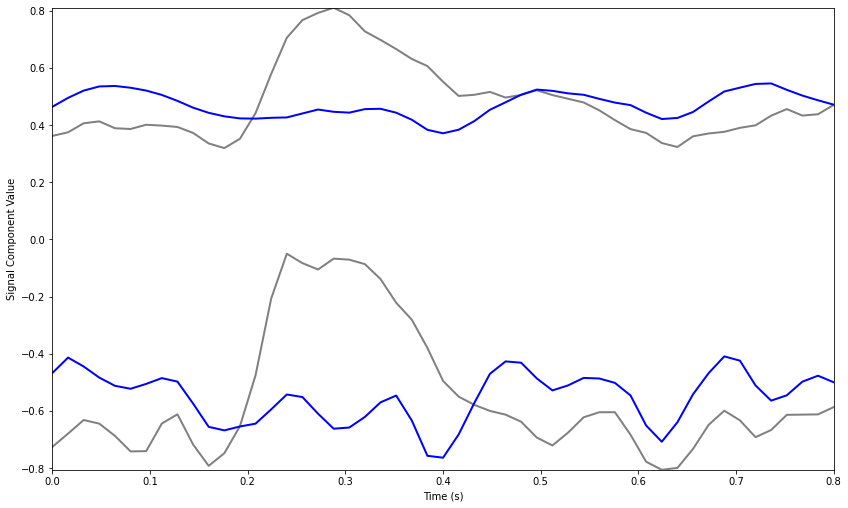

In [207]:
components = clogreg.components(std_valid_data)

target_components = components[valid_labels == 0].mean(0)
nontarget_components = components[valid_labels == 1].mean(0)
time = np.linspace(0.0, 0.8, components.shape[1])

plt.plot(time, nontarget_components, linewidth=2, color='grey', label='Nontarget');
plt.plot(time, target_components, linewidth=2, color='blue', label='Target');
plt.xlabel('Time (s)');
plt.ylabel('Signal Component Value');
plt.autoscale(tight=True);

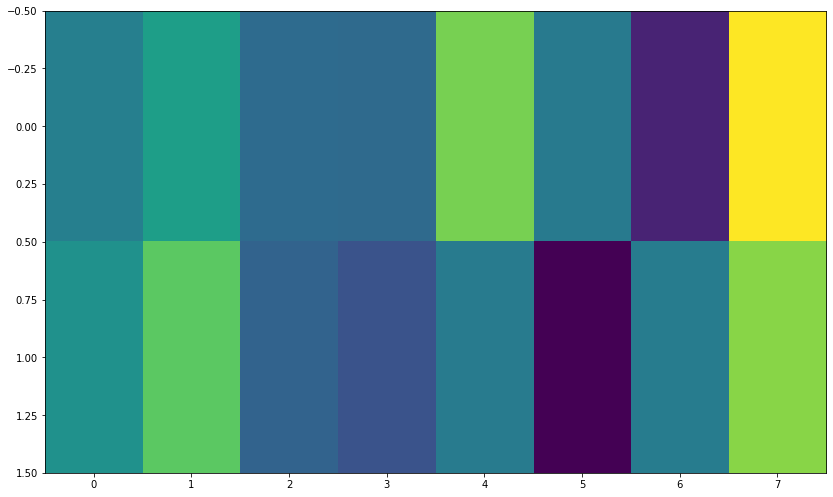

In [208]:
component_weights = clogreg.component_proj.weight.detach().numpy()

plt.imshow(component_weights, aspect='auto');

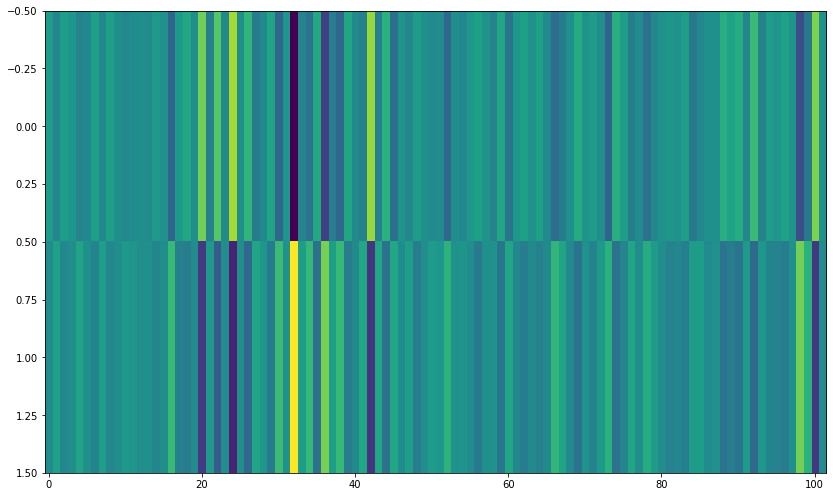

In [209]:
weights = clogreg.visible.weight.detach().numpy()

plt.imshow(weights, aspect='auto');

## Single-axis Convolutional Network with Dense Readout Layers

In [358]:
class ConvNet1D(P300Classifier):
    '''Single-axis Convolutional Neural Network with stride pooling and
    dense readout layers.
    '''
    def __init__(self, nchan, nstep, conv_specs, ndense, ncls, dropout=0.2, transfer=th.nn.Tanh):
        super().__init__()
        
        self.nchan = nchan
        self.ncls = ncls
        self.ndense = ndense
        
        layer_in, layer_out = None, nchan
        convs = []
        for units, width, stride in conv_specs:
            layer_in, layer_out = layer_out, units
            convs.append(th.nn.Dropout(dropout))
            convs.append(
                th.nn.Conv1d(
                    layer_in, layer_out,
                    kernel_size=width)),
            convs.append(th.nn.AvgPool1d(stride))
            convs.append(transfer())
            
            nstep = (nstep - width + 1) // stride
        
        self.convs = th.nn.Sequential(*convs)
        self.nconv_out = layer_out
        
        self.dense = th.nn.Sequential(
            th.nn.Dropout(dropout),
            th.nn.Linear(self.nconv_out * nstep, self.ndense),
            transfer(),
        )
        
        self.visible = th.nn.Linear(self.ndense, ncls)
        
    @numpy_func
    def components(self, data):
        return self.convs(data.permute(0, 2, 1)).permute(0, 2, 1)
        
    def forward(self, data):
        data = th.as_tensor(data, dtype=th.float32)
        assert data.ndim == 3
        nobs, nstep, nchan = data.shape
        
        conv_out = self.convs(data.permute(0, 2, 1))
        assert conv_out.ndim == 3
        assert conv_out.shape[0] == nobs
        assert conv_out.shape[1] == self.nconv_out
        
        conv_flat = conv_out.reshape((nobs, -1))
        dense_out = self.dense(conv_flat)
        assert dense_out.ndim == 2
        assert dense_out.shape[0] == nobs
        assert dense_out.shape[1] == self.ndense
        
        visible_out = self.visible(dense_out)
        assert visible_out.ndim == 2
        assert visible_out.shape[0] == nobs
        assert visible_out.shape[1] == self.ncls
        
        return visible_out

In [359]:
std_train_data.shape

(960, 51, 8)

In [370]:
cnn = ConvNet1D(
    nchan=std_train_data.shape[2],
    nstep=std_train_data.shape[1],
    conv_specs=((8, 5, 2), (8, 5, 2)),
    ndense=6,
    ncls=2)
print('model parameters:', sum(params.nelement() for params in cnn.parameters()))

model parameters: 1108


In [371]:
cnn_result = cnn.fit(std_train_data, train_labels, std_valid_data, valid_labels, maxiter=350)

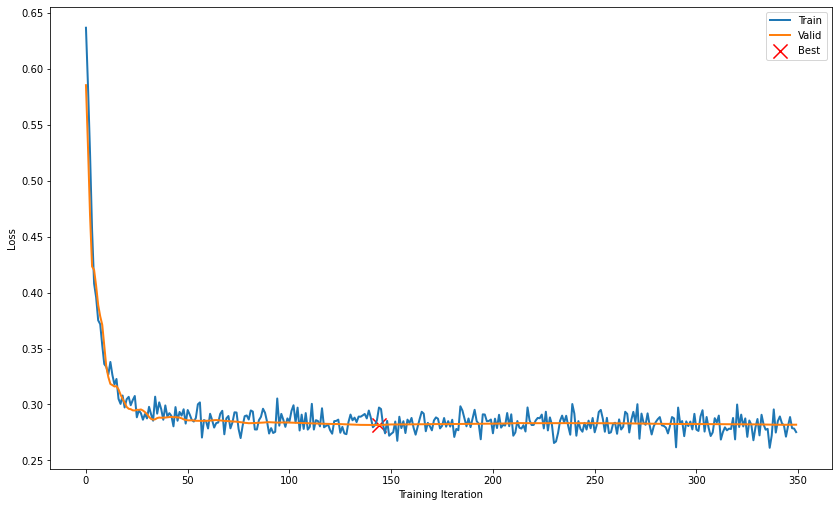

In [372]:
plt.plot(cnn_result.train_losses, linewidth=2, label='Train');
plt.plot(cnn_result.valid_losses, linewidth=2, label='Valid');
plt.scatter((cnn_result.best_iter,), (cnn_result.best_valid_loss,), marker='x', s=200, color='red', label='Best');
plt.legend();
plt.xlabel('Training Iteration');
plt.ylabel('Loss');

In [373]:
model = cnn

print('train CA:', model.ca(std_train_data, train_labels))
print('valid CA:', model.ca(std_valid_data, valid_labels))
print('test CA:', model.ca(std_test_data, test_labels))
print('-------')
print('train BCA:', model.bca(std_train_data, train_labels))
print('valid BCA:', model.bca(std_valid_data, valid_labels))
print('test BCA:', model.bca(std_test_data, test_labels))
print('-------')
print('train AUC:', model.auc(std_train_data, train_labels))
print('valid AUC:', model.auc(std_valid_data, valid_labels))
print('test AUC:', model.auc(std_test_data, test_labels))

train CA: 0.903125
valid CA: 0.8866666666666667
test CA: 0.8833333333333333
-------
train BCA: 0.764375
valid BCA: 0.7
test BCA: 0.742
-------
train AUC: 0.921984375
valid AUC: 0.8916999999999999
test AUC: 0.8981600000000001


(600, 9, 8)


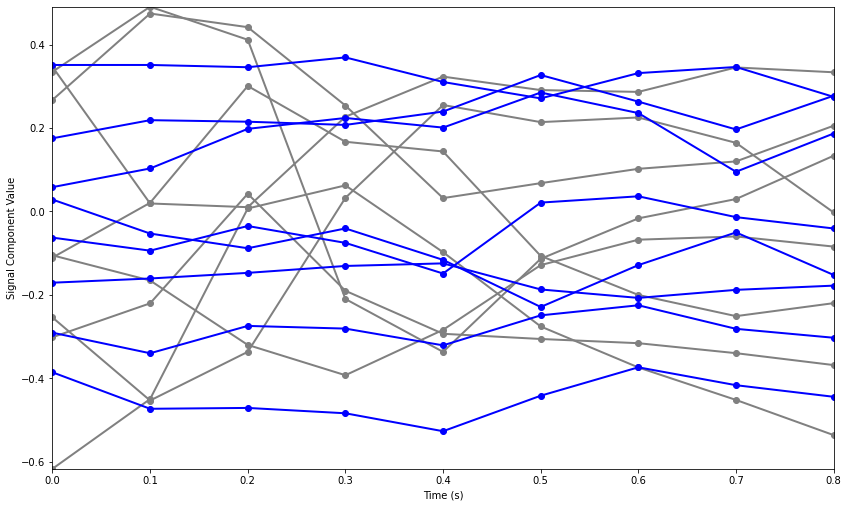

In [374]:
components = cnn.components(std_valid_data)

print(components.shape)

target_components = components[valid_labels == 0].mean(0)
nontarget_components = components[valid_labels == 1].mean(0)
time = np.linspace(0.0, 0.8, components.shape[1])

plt.plot(time, nontarget_components, linewidth=2, color='grey', marker='o', label='Nontarget');
plt.plot(time, target_components, linewidth=2, color='blue', marker='o', label='Target');
plt.xlabel('Time (s)');
plt.ylabel('Signal Component Value');
plt.autoscale(tight=True);